In [ ]:
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
folder_path = None  # replace with the directory where you will save the models to and load the models from.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class VAE(nn.Module):
  # feel free to define your arguments
  def __init__(self, hidden_dim, latent_dim, class_emb_dim, num_classes=10):
    super().__init__()

    self.latent_dim = latent_dim

    self.encoder = nn.Sequential(
       nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
       nn.ReLU(),
       nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
       nn.ReLU(),
       nn.Flatten(),
       nn.Linear(64 * 7 * 7, hidden_dim),
       nn.ReLU()
    ) # implement your encoder here

    # defining the network to estimate the mean
    self.mu_net = nn.Linear(hidden_dim + class_emb_dim, latent_dim) # implement your mean estimation module here

    # defining the network to estimate the log-variance
    self.logvar_net = nn.Linear(hidden_dim + class_emb_dim, latent_dim) # implement your log-variance estimation here

    # defining the class embedding module
    self.class_embedding = nn.Embedding(num_classes, class_emb_dim) # implement your class-embedding module here

    # defining the decoder here
    self.decoder = nn.Sequential(
       nn.Linear(latent_dim + class_emb_dim, 64 * 7 * 7),
       nn.ReLU(),
       nn.Unflatten(1, (64, 7, 7)),
       nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
       nn.ReLU(),
       nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
       nn.Sigmoid()
    ) # implement your decoder here

  def forward(self, x: torch.Tensor, y: torch.Tensor):
    """
    Args:
        x (torch.Tensor): image [B, 1, 28, 28]
        y (torch.Tensor): labels [B]

    Returns:
        reconstructed: image [B, 1, 28, 28]
        mu: [B, latent_dim]
        logvar: [B, latent_dim]
    """
    # implement your forward function here
    x = self.encoder(x)
    class_embeds = self.class_embedding(y)
    x = torch.cat([x, class_embeds], dim=1)
    mu = self.mu_net(x)
    logvar = self.logvar_net(x)
    z = self.reparameterize(mu, logvar)
    reconstructed = self.decoder(torch.cat([z, class_embeds], dim=1))
    return reconstructed, mu, logvar

  def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor):
    """
    applies the reparameterization trick
    """
    epsilon = torch.randn_like(logvar)
    new_sample = mu + epsilon * torch.exp(0.5 * logvar) # using the mu and logvar generate a sample
    return new_sample

  def kl_loss(self, mu, logvar):
    """
    calculates the KL divergence between a normal distribution with mean "mu" and
    log-variance "logvar" and the standard normal distribution (mean=0, var=1)
    """
    kl_div = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar) # calculate the kl-div using mu and logvar
    return kl_div

  def get_loss(self, x: torch.Tensor, y: torch.Tensor):
    """
    given the image x, and the label y calculates the prior loss and reconstruction loss
    """
    reconstructed, mu, logvar = self.forward(x, y)
    # reconstruction loss
    # compute the reconstruction loss here using the "reconstructed" variable above
    recons_loss = nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    # prior matching loss
    prior_loss = self.kl_loss(mu, logvar)
    return recons_loss, prior_loss

  @torch.no_grad()
  def generate_sample(self, num_images: int, y, device):
    """
    generates num_images samples by passing noise to the model's decoder
    if y is not None (e.g., y = torch.tensor([1, 2, 3]).to(device)) the model
    generates samples according to the specified labels

    Returns:
        samples: [num_images, 1, 28, 28]
    """
    # sample from noise, find the class embedding and use both in the decoder to generate new samples
    z_sample = torch.randn(num_images, self.latent_dim).to(device)
    class_embeds = self.class_embedding(y)
    samples = self.decoder(torch.cat([z_sample, class_embeds], dim=1)).detach().cpu()
    return samples.to(device)


def load_vae_and_generate():
    device = torch.device('cuda')
    vae = VAE(hidden_dim=400, latent_dim=200, class_emb_dim=50, num_classes=10).to(device) # define your VAE model according to your implementation above
    # loading the weights of VAE
    vae.load_state_dict(torch.load(folder_path + 'vae.pt'))
    vae = vae.to(device)
    desired_labels = []
    for i in range(10):
        for _ in range(5):
            desired_labels.append(i)
    desired_labels = torch.tensor(desired_labels).to(device)
    generated_samples = vae.generate_sample(50, desired_labels, device)
    return generated_samples

In [ ]:
kwargs = {'root':'datasets/FashionMNIST',
          'train':True,
          'transform':transforms.ToTensor(),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

In [ ]:
def train(vae: VAE,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          reg_factor: float=1.,
          device=torch.device('cuda'),
          display_interval: int=5):

  itrs = tqdm(range(epochs))
  itrs.set_description(f'Train Recons Loss: ? - Train Prior Loss: ? (Total: ?)- '
                       f'Val Recons Loss: ? - Val Prior Loss: ? (Total: ?)')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    avg_prior_loss = 0.
    avg_recons_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      y = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      recons_loss, prior_loss = vae.get_loss(x, y)

      loss = recons_loss + reg_factor * prior_loss

      avg_prior_loss += prior_loss.item()
      avg_recons_loss += recons_loss.item()
      avg_train_loss += loss.item()

      loss.backward()
      optimizer.step()

    avg_recons_loss /= len(train_loader)
    avg_prior_loss /= len(train_loader)
    avg_train_loss /= len(train_loader)

    # validation and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      avg_val_prior_loss = 0.
      avg_val_recons_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        y = sample[1].type(torch.long).to(device)

        recons_loss, prior_loss = vae.get_loss(x, y)

        loss = recons_loss + reg_factor * prior_loss

        avg_val_prior_loss += prior_loss.item()
        avg_val_recons_loss += recons_loss.item()
        avg_val_loss += loss.item()

      avg_val_prior_loss /= len(val_loader)
      avg_val_recons_loss /= len(val_loader)
      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Recons Loss: {avg_recons_loss:.3f} - Train Prior Loss: {avg_prior_loss:.3f} (Total: {avg_train_loss:.3f})- '
                         f'Val Recons Loss: {avg_val_recons_loss:.3f} - Val Prior Loss: {avg_val_prior_loss:.3f} (Total: {avg_val_loss:.3f})')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(vae.state_dict(), folder_path + 'vae.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = vae.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Recons Loss: 27460.684 - Train Prior Loss: 994.515 (Total: 28455.199)- Val Recons Loss: 25049.350 - Val Prior Loss: 1059.613 (Total: 26108.963):   0%|          | 0/10 [00:18<?, ?it/s]

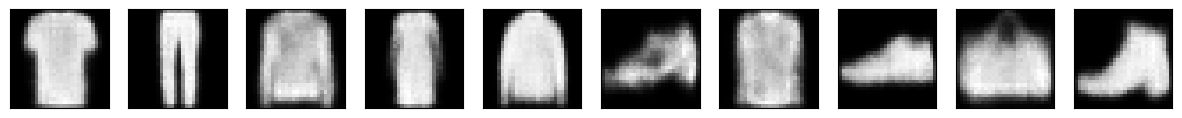

Train Recons Loss: 23102.773 - Train Prior Loss: 1209.845 (Total: 24312.618)- Val Recons Loss: 22944.647 - Val Prior Loss: 1207.552 (Total: 24152.199):  50%|█████     | 5/10 [01:05<00:51, 10.26s/it]

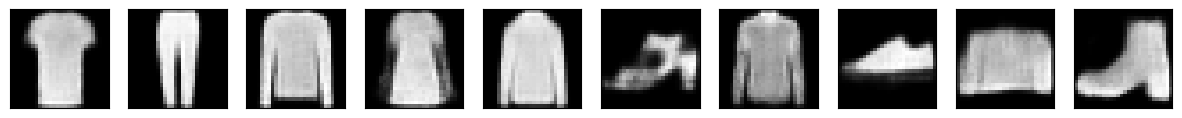

Train Recons Loss: 22606.085 - Train Prior Loss: 1243.686 (Total: 23849.772)- Val Recons Loss: 22472.470 - Val Prior Loss: 1299.468 (Total: 23771.938):  90%|█████████ | 9/10 [01:44<00:09,  9.53s/it]

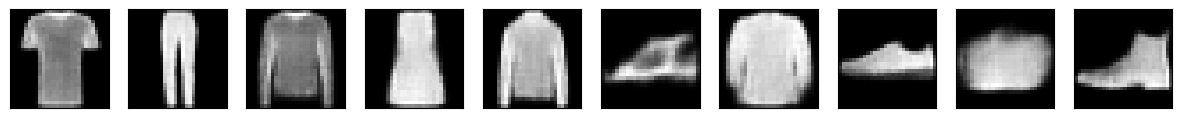

Train Recons Loss: 22606.085 - Train Prior Loss: 1243.686 (Total: 23849.772)- Val Recons Loss: 22472.470 - Val Prior Loss: 1299.468 (Total: 23771.938): 100%|██████████| 10/10 [01:44<00:00, 10.48s/it]


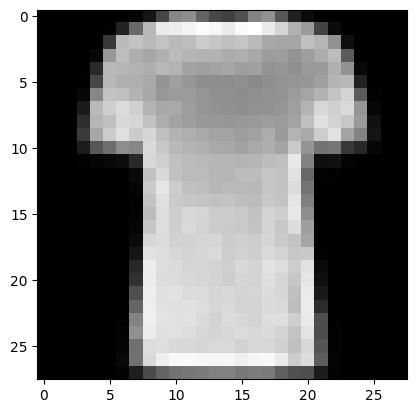

In [ ]:
# setting the training hyperparameters
device = torch.device('cuda')
batch_size = 100 # specify your batch size
vae = VAE(hidden_dim=400, latent_dim=200, class_emb_dim=50, num_classes=10).to(device) # load your model here
lr = 1e-3 # specify yout
optimizer = optim.Adam(vae.parameters(), lr=lr) # specify your optimizer; e.g. optim.Adam(vae.parameters(), lr)
reg_factor = 1 # specify the regularization factor for the prior matching loss
epochs = 10 # feel free to change the epochs as needed
num_classes = 10
display_interval = 5 # feel free to change; set to None if you do not want to see generated images during the training

# defining the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# moving the model to gpu
vae = vae.to(device)

# training the model
train(vae=vae,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      reg_factor=reg_factor,
      device=device,
      display_interval=display_interval)

generated_sample = vae.generate_sample(1, torch.tensor([0]).cuda(), device)

plt.imshow(generated_sample[0].squeeze(0).cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
# a classifier trained on FashionMNIST (DO NOT CHANGE THE CODE BELOW)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

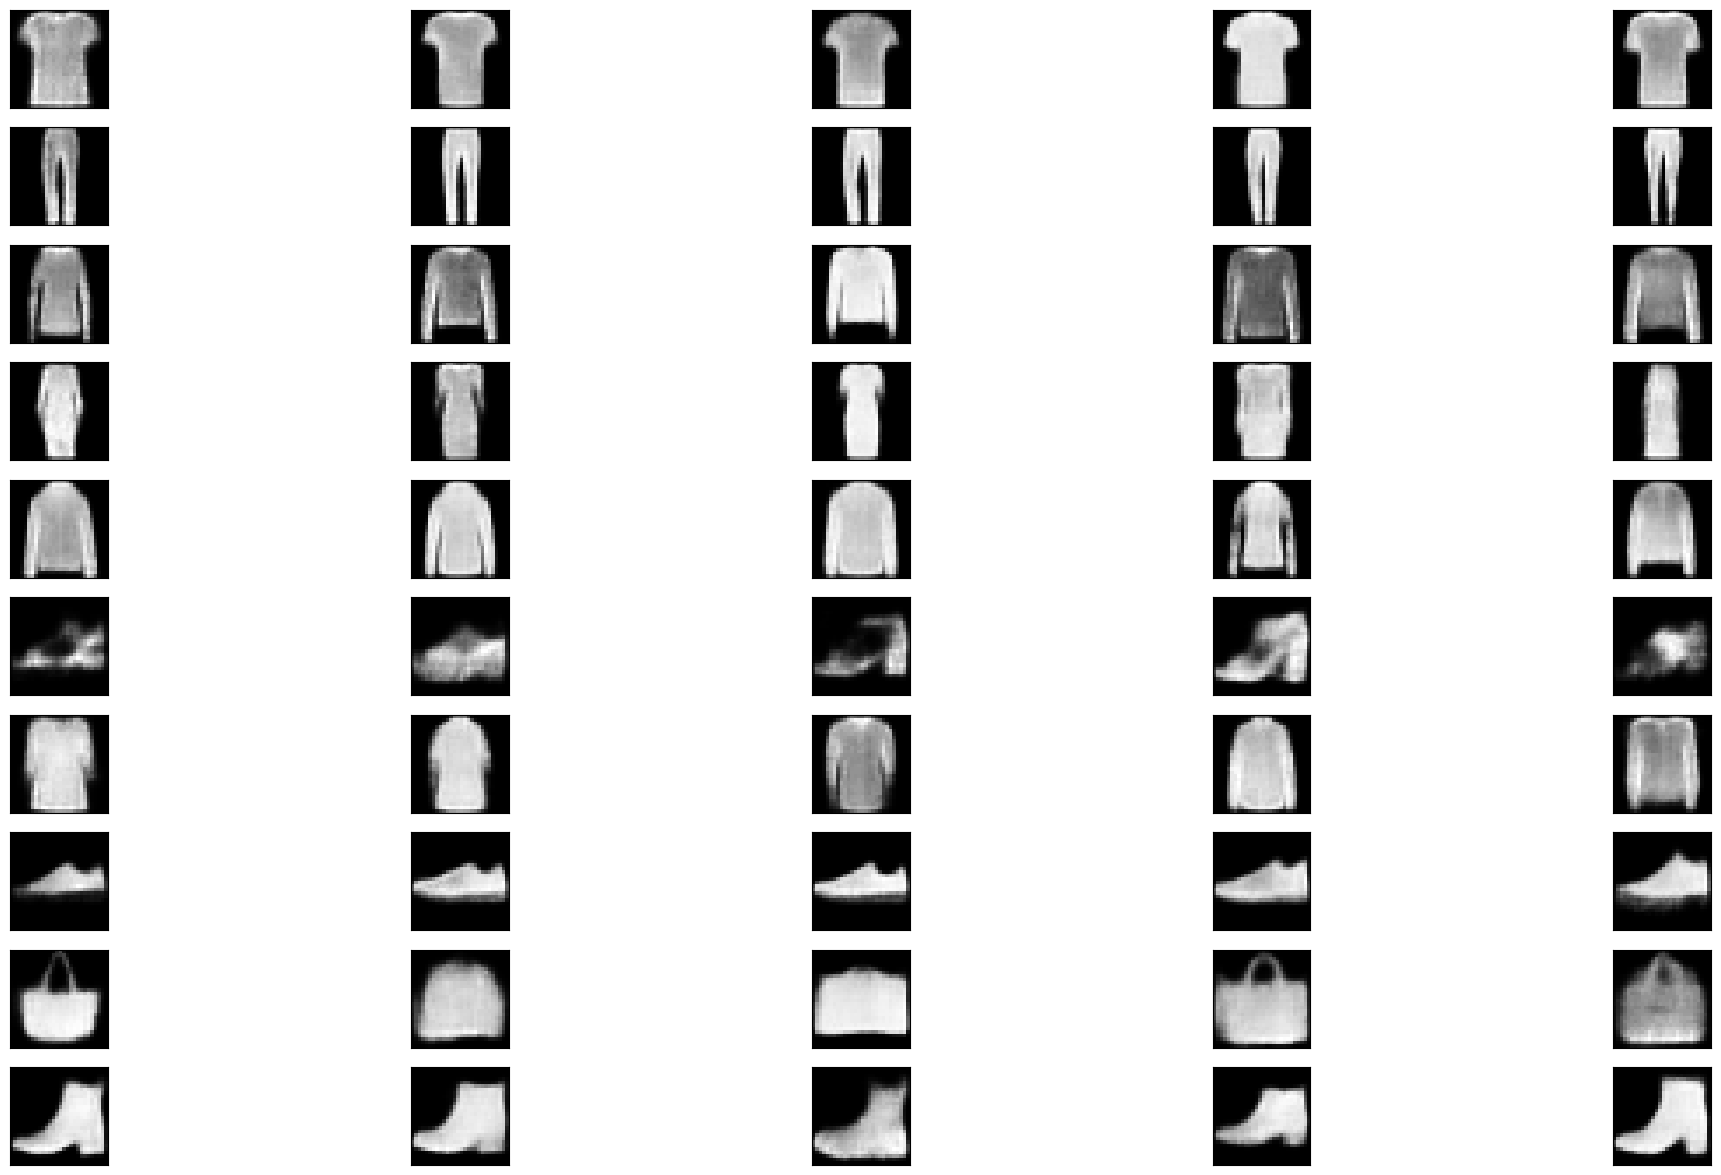

tensor([6, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 7, 5, 9, 7, 6, 4, 0, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
88.00


In [ ]:
# here we use the classifier to see if how well it can classify the generated images (do not change the following code)
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).cuda()

# load your vae
vae.load_state_dict(torch.load(folder_path + 'vae.pt'))
vae = vae.to(device)

# generate samples from the VAE
generated_samples = vae.generate_sample(50, desired_labels, torch.device('cuda'))

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load(folder_path + 'classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')